<a href="https://colab.research.google.com/github/angulartist/cnn-ensembles-mnist/blob/master/cnn_ensembles_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# [Google Colab] Handle older TF versions.
%tensorflow_version 1.x 

import tensorflow as tf
# Check if we're using a GPU:
# Should print : /device:GPU:0 if True.
print('GPU Support:', tf.test.gpu_device_name())

import os

from google.colab import drive

from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob

matplotlib.use('Agg')
%matplotlib inline

GPU Support: /device:GPU:0


# (Optional/Google Colab) Setup working directory



In [3]:
WORKSPACE_PATH = 'deepl/'

drive.mount('/content/gdrive')
ROOT_DIR  = '/content/gdrive/My Drive/'
BASE_DIR  = os.path.join(ROOT_DIR, WORKSPACE_PATH)

print('Workspace:', BASE_DIR)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
Workspace: /content/gdrive/My Drive/deepl/


# Load the MNIST dataset from Keras

In [4]:
(X_train, y_train), (X_ttest, y_ttest) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [5]:
print('Train set shape:', X_train.shape)
print('Test  set shape:', X_ttest.shape)

Train set shape: (60000, 28, 28)
Test  set shape: (10000, 28, 28)


# Dataviz

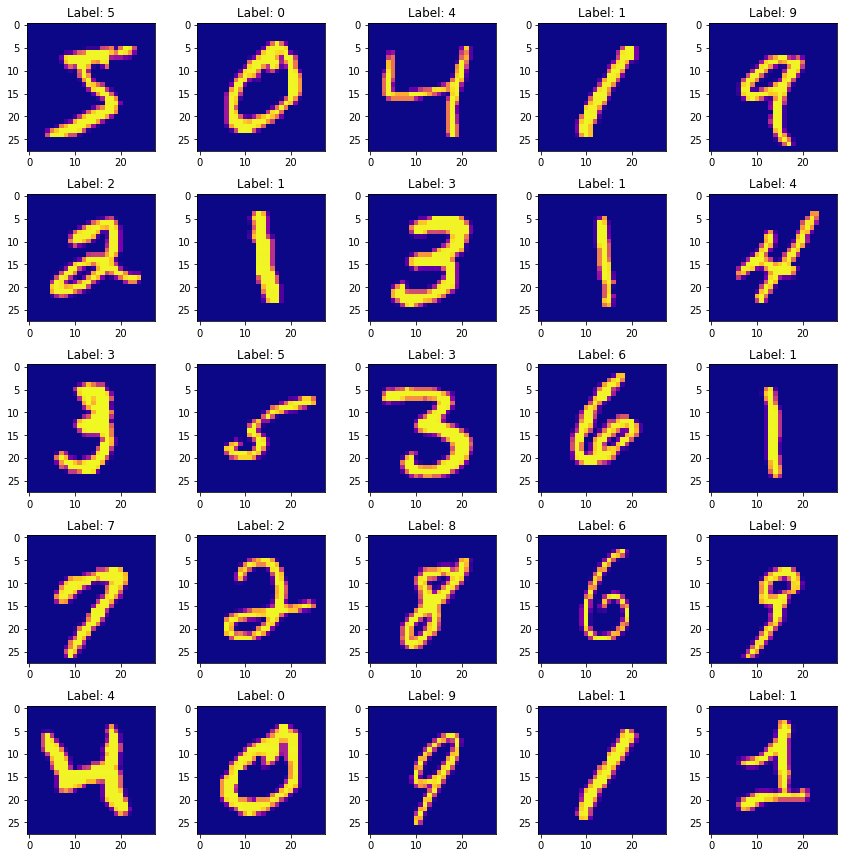

In [6]:
(samples_X, samples_y) = (X_train[:25], y_train[:25])

fig, ax = plt.subplots(
    nrows=5,
    ncols=5,
    figsize=[12, 12]
)

for i, fig in enumerate(ax.flat):
    fig.imshow(samples_X[i], cmap='plasma')
    fig.set_title(f'Label: {samples_y[i]}')

plt.tight_layout(True)

# Data enrichment

In [7]:
X_df = pd.read_csv(os.path.join(BASE_DIR, 'train.csv.zip'))
print('Kaggle train set shape:', X_df.shape)
X_df.head()

Kaggle train set shape: (42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
# Extract the pixel intensities.
X = X_df.iloc[:, 1:]
X = X.values

# Extract the labels.
y = X_df.iloc[:, 0]
y = y.values

pd.DataFrame(y)

,0
0,1
1,0
2,1
3,4
4,0
...,...
41995,0
41996,1
41997,7
41998,6


# Reshape datasets

In [9]:
'''
To be able to train a model with this dataset,
we first need to reshape both the train set and the test set
that way the number of samples is the first entry in the matrix,
the single channel as the second entry, followed by the number of rows and columns.

(num_samples, rows, columns, channel)
'''

X_train = X_train.reshape(-1, 28, 28, 1)
X_ttest = X_ttest.reshape(-1, 28, 28, 1)

print('Train set shape:', X_train.shape)
print('Test  set shape:', X_ttest.shape)

Train set shape: (60000, 28, 28, 1)
Test  set shape: (10000, 28, 28, 1)


In [10]:
'''
Now, we're going to concatenate the train set
we got from Keras with the dataset we've downloaded
from the Kaggle competition.

Let's reshape it too.
'''

X = X.reshape(-1, 28, 28, 1)

print('Train alt set shape:', X.shape)

Train alt set shape: (42000, 28, 28, 1)


In [11]:
'''
Calling np.concatenate will produce
a numpy array representing 102000 training samples
of 28x28x1 dimension and a numpy array
containing 102000 labels.
'''

X_train = np.concatenate((X_train, X), axis=0)
y_train = np.concatenate((y_train, y), axis=0)

print('Final train set shape:', X_train.shape)
print('Final train labels:', y_train.shape)

Final train set shape: (102000, 28, 28, 1)
Final train labels: (102000,)


# Normalize pixel intensities to range [0, 1]

In [0]:
'''
Normalization of pixel intensities is adjusting values measured on different scales
to a notionally common scale. That's a best practice you have to follow because weights
reach optimum values faster. Therefore, the network converges faster.

So, instead of having pixel intensities in the range [0, 255] in the gray-scale color-space,
we're going to scale them into the range [0, 1].

There are many normalization techniques and this is one of them.
'''

(X_train, X_ttest) = (child.astype('float32') / 255.0 for child in [X_train, X_ttest])

# One-Hot Encode labels


In [13]:
'''
Now, our previous integer labels are converted to vector labels.
This process is called one-hot encoding and most of the machine learning algorithms
benefit from this label representation. 2 = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
8 = [0, 0, 0, 0, 0, 0, 0, 0, 1, 0].

Imagine that you have 3 categories: Cat, Dog, and Lama.
We first need to convert them to numeric values 1, 2 and 3
so our algorithm is able to do its work.

But, giving these values to the algorithm will lead to mistakes.
In fact, there is no relationship between these categories,
and you algorithm may try to compute the average and...
the average of Cat, Dog, and Lama has no sens. The opposite
example would be Cold, Warm, Hot, Very Hot.

That's why we have to use one-hot encoding.

We could also use the to_categorical() function from Keras which yields the exact same values.
'''

lb = LabelBinarizer()
(y_train, y_ttest) = (lb.fit_transform(labels) for labels in [y_train, y_ttest])
pd.DataFrame(y_train)

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,1,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
101995,1,0,0,0,0,0,0,0,0,0
101996,0,1,0,0,0,0,0,0,0,0
101997,0,0,0,0,0,0,0,1,0,0
101998,0,0,0,0,0,0,1,0,0,0


# Data Augmentation

In [0]:
'''
Let's apply some data augmentation.

Data augmentation is a set of techniques used to generate new training samples from the original ones
by applying jitters and perturbations such that the classes labels are not changed.
In the context of computer vision, these random transformations can be translating,
rotating, scaling, shearing, flipping etc.

Data augmentation is a form of regularization because the training algorithm is being
constantly presented with new training samples,
allowing it to learn more robust and discriminative patterns
and reducing overfitting.
'''

daug = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=11,
    zoom_range = 0.15, 
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=False,
    vertical_flip=False
)

# Build the model

In [0]:
'''
Here, we've imported our CNN.

Pay attention to Batch Normalization and Dropout layers
which help to reduce overfitting.
'''

from tensorflow.keras.models import Model
from tensorflow.keras import Input
from tensorflow.keras import layers

class CustomNet(object):
  @staticmethod
  def build(width, height, num_classes, depth=3):
      input_shape = (height, width, depth)
      chan_dim = -1
      
      input_tensor = Input(shape=input_shape)
      x = layers.SeparableConv2D(64,  (5, 5), padding='same', activation='relu')(input_tensor)
      x = layers.BatchNormalization(axis=chan_dim)(x)
      x = layers.SeparableConv2D(128, (5, 5), padding='same', activation='relu')(x)
      x = layers.BatchNormalization(axis=chan_dim)(x)
      x = layers.SeparableConv2D(128, (3, 3), padding='same', activation='relu')(x)
      x = layers.BatchNormalization(axis=chan_dim)(x)
      x = layers.MaxPooling2D(pool_size=(2, 2))(x)
      x = layers.Dropout(0.1)(x)

      x = layers.SeparableConv2D(128, (3, 3), padding='same', activation='relu')(x)
      x = layers.BatchNormalization(axis=chan_dim)(x)
      x = layers.SeparableConv2D(128, (3, 3), padding='same', activation='relu')(x)
      x = layers.BatchNormalization(axis=chan_dim)(x)
      x = layers.SeparableConv2D(128, (3, 3), padding='same', activation='relu')(x)
      x = layers.BatchNormalization(axis=chan_dim)(x)
      x = layers.MaxPooling2D(pool_size=(2, 2))(x)
      x = layers.Dropout(0.1)(x)
      
      '''
      Flat the last output volume
      into a column vector
      '''
      x = layers.Flatten()(x)
      x = layers.Dense(256, activation='relu')(x)
      x = layers.BatchNormalization(axis=chan_dim)(x)
      x = layers.Dropout(0.5)(x)

      '''
      Add a final fully connected layer:
      There are as many neurons as there are outputs (10 -> [0..9])
      '''
      output_tensor = layers.Dense(num_classes, activation='softmax')(x)

      model = Model(input_tensor, output_tensor)

      return model

In [0]:
'''
When the model has seen all of your training samples, we say that one epoch has passed.
We're going to train the model for N epochs.
'''

num_epochs = 50

'''
Instead of updating our weights after each epoch,
which is slow and computationally wasteful,
we'll update them for each mini-batch of samples.
'''
batch_size = 32

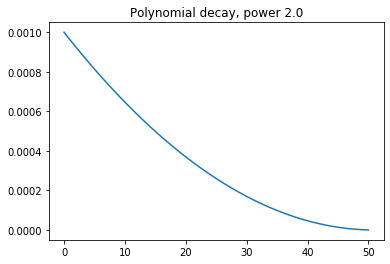

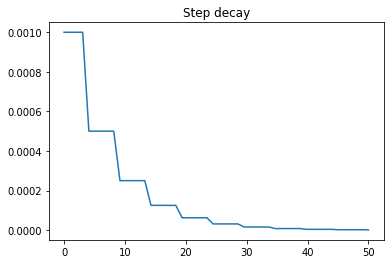

In [17]:
# Initial learning rate.
init_lr = 0.001

# Example 1: Polynomial decay.
def polynomial_decay(epoch):
    max_epochs = num_epochs
    base_lr = init_lr
    power = 2.0
    
    return base_lr * (1 - (epoch / float(max_epochs))) ** power

# Plot.
x = np.linspace(0, num_epochs)
fx = [init_lr * (1 - (i / float(num_epochs))) ** 2.0 for i in range(len(x))]
plt.plot(x, fx)
plt.title(label='Polynomial decay, power 2.0')
plt.show()

# Example 2: Step-based decay.
def step_decay(epoch):
  factor    = 0.5
  drop_rate = 5

  return float(init_lr * (factor ** np.floor((1 + epoch) / drop_rate)))

# Plot.
x = np.linspace(0, num_epochs)
fx = [float(init_lr * (0.5 ** np.floor((1 + i) / 5))) for i in range(len(x))]
plt.plot(x, fx)
plt.title(label=f'Step decay')
plt.show()

# Set the optimizer and hyperparameters

In [18]:
for idx in range(3, 5):
  print('Will train model #:', idx)

  model = CustomNet.build(
      width=28,
      height=28,
      num_classes=10,
      depth=1)
  
  print('Built model #:', idx)

  rms = RMSprop(learning_rate=init_lr, rho=0.9)

  # (Optional) Saving best weights values.
  checkpointHandler = ModelCheckpoint(
      os.path.join(BASE_DIR, f'mnist_cnn_{idx}.h5'),
      monitor='val_loss',
      save_best_only=True,
      verbose=1
  )

  # Callbacks array.
  callbacks = [
      LearningRateScheduler(step_decay),
      checkpointHandler
  ]

  model.compile(
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    optimizer=rms
  )

  h = model.fit_generator(
    daug.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_ttest, y_ttest),
    epochs=num_epochs,
    steps_per_epoch=len(X_train) // batch_size,
    callbacks=callbacks,
    verbose=0
  )

  label_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
  preds = model.predict(X_ttest, batch_size=batch_size)
  report = classification_report(
      y_ttest.argmax(axis=1),
      preds.argmax(axis=1),
      target_names=label_names)

  with open(os.path.join(BASE_DIR, f'model_cnn_{idx}.txt'), 'w+') as f:
    f.write(report)


Will train model #: 3
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Built model #: 3

Epoch 00001: val_loss improved from inf to 0.09751, saving model to /content/gdrive/My Drive/deepl/mnist_cnn_3.h5

Epoch 00002: val_loss improved from 0.09751 to 0.03414, saving model to /content/gdrive/My Drive/deepl/mnist_cnn_3.h5

Epoch 00003: val_loss did not improve from 0.03414

Epoch 00004: val_loss improved from 0.03414 to 0.02237, saving model to /content/gdrive/My Drive/deepl/mnist_cnn_3.h5

Epoch 00005: val_loss improved from 0.02237 to 0.01284, saving model to /content/gdrive/My Drive/deepl/mnist_cnn_3.h5

Epoch 00006: val_loss did not improve from 0.01284

Epoch 00007: val_loss improved from 0.01284 to 0.01225, saving model to /content/gdrive/My Drive/deepl/mnist_cnn_3.h5

Epoch 00008: val_loss improved from 0.01225 to 0.01055, saving model to /content/gdrive/My Drive/deepl/mnist_cnn_3.h5

Epoch 00009: val_loss did not improve from 0.01055

Epoch 00010: 

In [19]:
model_paths = glob.glob(os.path.join(BASE_DIR, 'mnist_cnn_*.h5'))
models = [load_model(model) for model in model_paths]

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
sub_X_test = pd.read_csv(os.path.join(BASE_DIR, 'test.csv'))
sub_X_test = sub_X_test / 255.0
sub_X_test = sub_X_test.values.reshape(-1, 28, 28, 1)

preds = [model.predict(sub_X_test, batch_size=batch_size) for model in models]
preds = np.average(preds, axis=0)

In [21]:
preds.shape

(28000, 10)

In [22]:
classes = list(np.argmax(preds, axis=1))
id_col = np.arange(1, len(classes) + 1)                            # shift index
submission = pd.DataFrame({'ImageId': id_col, 'Label': classes})   # build a submission                                     
print(submission.head(20))
submission.to_csv(os.path.join(BASE_DIR, 'cnn_mnist_datagen.csv'), index=False)

print('Saved to:', os.path.join(BASE_DIR, 'cnn_mnist_datagen.csv'))

    ImageId  Label
0         1      2
1         2      0
2         3      9
3         4      0
4         5      3
5         6      7
6         7      0
7         8      3
8         9      0
9        10      3
10       11      5
11       12      7
12       13      4
13       14      0
14       15      4
15       16      3
16       17      3
17       18      1
18       19      9
19       20      0
Saved to: /content/gdrive/My Drive/deepl/cnn_mnist_datagen.csv
